$IMPORTING$ $ESSENTIAL$ $LIBRARIES$

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
torch.manual_seed(0)
import time
import os

$HYPERPARAMETERS$

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
learning_rate = 0.0001

$SPECIAL$ $FUNCTIONS$

In [4]:
# Function for getting parameters from user
def get_parameters():
    kernel_ = []
    for i in range(5):
        kernel_.append(input(print(f"Enter the number of kernel filters needed in your neural network layer{i}: ")))
    return kernel_

# Function for showing examples
def show_example(img):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    
# Function for showing data
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE),cmap = 'gray')
    plt.title('y = ' + str(data_sample[1]))



In [5]:
# TRANSFORMS 
# Transforms or data augmentation
transform_ = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomRotation((-30,30)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

$DATASET$   $LOADING$   $AND$   $SPLITTING$

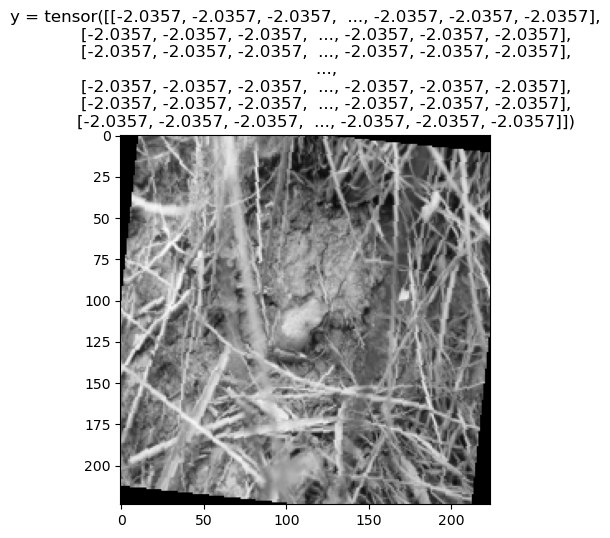

In [6]:
# Train and validation paths defined (dataset is present in local computer with the files located at the following locations)
train_path = 'D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/train'
val_path = 'D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/val'
data_path = 'D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K'

# Train and validation datasets defined
train_dataset = ImageFolder(train_path, transform=transform_)
val_dataset = ImageFolder(root = val_path, transform = transform_)

# Splitting the training data into 80-20 ratio for hyperparameter sweeping in wandb
train_set, sweep_set = torch.utils.data.random_split(train_dataset, [7999, 2000])



#Train and validation data loader defined
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

#Taking and displaying first class first image
show_data(val_dataset[0][0])

# train_loader = DataLoader(data_path, batch_size=32, shuffle=True)
# augmented_loader = augment_dataloader(train_loader, num_augmentations=10)

### PART-B Transfer Learning in PyTorch

$MODEL:$ $MobileNet$ $V3$

Here we train the model with pre-weights loaded and freezing them.
In the last part of the model, Fully Connected layers are custom defined 
and the output layer is defined based on our use case, here 10 classes.

$Mobilenet$ $V3$

In [11]:
# Loading the Vgg-19 model
model_v3 = models.mobilenet_v3_small(pretrained=True)
model_v3

C:\Users\bones\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [12]:
#Freezing the weights of the model 
for param in model_v3.parameters():
    param.requires_grad = False

# Defining final layers to be flexible (setting gradient to be True for training)
model_v3.classifier[0].requires_grad = True
model_v3.classifier[3].requires_grad = True
model_v3.classifier[0] = nn.Linear(576,1024)
model_v3.classifier[3] = nn.Linear(1024,10)
model_v3.classifier[2] = nn.Dropout(p=0.4, inplace = True)

In [27]:
class MobilenetV3(nn.Module):

    def __init__(self, num_classes=10):
        super(MobilenetV3, self).__init__()
        self.mobilenetv3 = models.mobilenet_v3_small(pretrained=True)
        self.fc = nn.Linear(576, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.mobilenetv3.features(x)
        x = self.mobilenetv3.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        
        return x

### Model Train

In [31]:
import torch.optim as optim

# Model, loss function, and optimizer are defined
model = MobilenetV3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training the model
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total_val = 0
    correct_val = 0
    
    # Train
    model.train()
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if i % 100 == 99:  # print every 100 mini-batches
            print('[%d, %5d] train loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
    # Validate
    model.eval()
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    print('[%d] train acc: %.3f, val acc: %.3f' % (epoch + 1, 100 * correct_train / total_train, 100 * correct_val / total_val))

print('Finished Training')

[1,   100] train loss: 2.096
[1,   200] train loss: 1.992
[1] train acc: 43.443, val acc: 41.600
[2,   100] train loss: 1.937
[2,   200] train loss: 1.947
[2] train acc: 52.094, val acc: 45.450
[3,   100] train loss: 1.911
[3,   200] train loss: 1.906
[3] train acc: 54.907, val acc: 49.900
[4,   100] train loss: 1.896
[4,   200] train loss: 1.889
[4] train acc: 56.357, val acc: 50.400
[5,   100] train loss: 1.875
[5,   200] train loss: 1.893
[5] train acc: 57.270, val acc: 51.700
[6,   100] train loss: 1.850
[6,   200] train loss: 1.871
[6] train acc: 59.820, val acc: 53.550
[7,   100] train loss: 1.843
[7,   200] train loss: 1.846
[7] train acc: 61.345, val acc: 56.600
[8,   100] train loss: 1.828
[8,   200] train loss: 1.835
[8] train acc: 63.095, val acc: 54.150
[9,   100] train loss: 1.818
[9,   200] train loss: 1.824
[9] train acc: 63.670, val acc: 48.750
[10,   100] train loss: 1.839
[10,   200] train loss: 1.830
[10] train acc: 62.783, val acc: 55.400
[11,   100] train loss: 1.7